In [1]:
import glob
import os
import shutil
from os import path as osp
from urllib.error import URLError

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from spektral.layers import GATConv #,GINConv,GCNConv #, GCSConv, GlobalAvgPool
from spektral.data import Dataset, Graph, DisjointLoader, SingleLoader
from spektral.datasets.utils import download_file
from spektral.utils import io, sparse
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.utils import tic, toc

#tf.random.set_seed(0)


####################

## Exploración de los datos de PROTEINS

(Ignorar hasta el siguiente título)

In [2]:
name = "PROTEINS"
path = "/root/spektral/datasets/TUDataset/PROTEINS"
fname_template = osp.join(path, "{}_{{}}.txt".format(name))
available = [
            f.split(os.sep)[-1][len(name) + 1 : -4]  # Remove leading name
            for f in glob.glob(fname_template.format("*"))
]

In [3]:
available

['graph_indicator', 'node_attributes', 'A', 'node_labels', 'graph_labels']

In [5]:
# Batch index
node_batch_index = (
            io.load_txt(fname_template.format("graph_indicator")).astype(int) - 1
)
n_nodes = np.bincount(node_batch_index)
n_nodes_cum = np.concatenate(([0], np.cumsum(n_nodes)[:-1]))
print(n_nodes_cum)

[    0    42    69 ... 43410 43426 43431]


In [22]:
# Read edge lists
edges = io.load_txt(fname_template.format("A"), delimiter=",").astype(int) - 1
# Remove duplicates and self-loops from edges
_, mask = np.unique(edges, axis=0, return_index=True)
mask = mask[edges[mask, 0] != edges[mask, 1]]
edges = edges[mask]
# Split edges into separate edge lists
edge_batch_idx = node_batch_index[edges[:, 0]]
n_edges = np.bincount(edge_batch_idx)
n_edges_cum = np.cumsum(n_edges[:-1])
el_list = np.split(edges - n_nodes_cum[edge_batch_idx, None], n_edges_cum)


In [6]:
def _normalize(x, norm=None):
    """
    Apply one-hot encoding or z-score to a list of node features
    """
    if norm == "ohe":
        fnorm = OneHotEncoder(sparse=False, categories="auto")
    elif norm == "zscore":
        fnorm = StandardScaler()
    else:
        return x
    return fnorm.fit_transform(x)


In [24]:
# Node features
x_list = []
if "node_attributes" in available:
    x_attr = io.load_txt(fname_template.format("node_attributes"), delimiter=",")
    if x_attr.ndim == 1:
        x_attr = x_attr[:, None]
    x_list.append(x_attr)
#if "node_labels" in available:
#    x_labs = io.load_txt(fname_template.format("node_labels"))
#    if x_labs.ndim == 1:
#        x_labs = x_labs[:, None]
#    x_labs = np.concatenate([_normalize(xl_[:, None], "ohe") for xl_ in x_labs.T], -1)
#    x_list.append(x_labs)
if len(x_list) > 0:
    x_list = np.concatenate(x_list, -1)
    x_list = np.split(x_list, n_nodes_cum[1:])
else:
    print(
            "WARNING: this dataset doesn't have node attributes."
            "Consider creating manual features before using it with a "
            "Loader."
        )
    x_list = [None] * len(n_nodes)


In [25]:
len(x_list)

1113

In [26]:
# Edge features
e_list = []
if "edge_attributes" in available:
    e_attr = io.load_txt(fname_template.format("edge_attributes"))
    if e_attr.ndim == 1:
        e_attr = e_attr[:, None]
    e_attr = e_attr[mask]
    e_list.append(e_attr)
if "edge_labels" in available:
    e_labs = io.load_txt(fname_template.format("edge_labels"))
    if e_labs.ndim == 1:
        e_labs = e_labs[:, None]
    e_labs = e_labs[mask]
    e_labs = np.concatenate(
        [_normalize(el_[:, None], "ohe") for el_ in e_labs.T], -1
    )
    e_list.append(e_labs)
if len(e_list) > 0:
    e_available = True
    e_list = np.concatenate(e_list, -1)
    e_list = np.split(e_list, n_edges_cum)
else:
    e_available = False
    e_list = [None] * len(n_nodes)

# Create sparse adjacency matrices and re-sort edge attributes in lexicographic
# order
a_e_list = [
    sparse.edge_index_to_matrix(
        edge_index=el,
        edge_weight=np.ones(el.shape[0]),
        edge_features=e,
        shape=(n, n),
    )
    for el, e, n in zip(el_list, e_list, n_nodes)
]
if e_available:
    a_list, e_list = list(zip(*a_e_list))
else:
    a_list = a_e_list


In [27]:
len(a_list)

1113

In [15]:
# Labels
if "graph_attributes" in available:
    labels = io.load_txt(fname_template.format("graph_attributes"))
elif "graph_labels" in available:
    labels = io.load_txt(fname_template.format("graph_labels"))
    labels = _normalize(labels[:, None], "ohe")
else:
    raise ValueError("No labels available for dataset {}".format(self.name))


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
len(labels), labels.shape

(1113, (1113, 2))

In [7]:
# Labels
labels = []
if "node_labels" in available:
    x_labs = io.load_txt(fname_template.format("node_labels"))
    if x_labs.ndim == 1:
        x_labs = x_labs[:, None]
    x_labs = np.concatenate([_normalize(xl_[:, None], "ohe") for xl_ in x_labs.T], -1)
    labels.append(x_labs)
if len(labels) > 0:
    labels = np.concatenate(labels, -1)
    labels = np.split(labels, n_nodes_cum[1:])
    
print(x_labs)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
filtrado = x_labs[x_labs[:,2] == 0., :]
#filtered_nodes = set(filtrado['node'].tolist())
print(filtrado)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [23]:
x_labs[:,2]

array([0., 0., 0., ..., 1., 1., 1.])

In [12]:
if "node_labels" in available:
    x_labs = io.load_txt(fname_template.format("node_labels"))
    if x_labs.ndim == 1:
        x_labs = x_labs[:, None]
    x_labs = np.concatenate([_normalize(xl_[:, None], "ohe") for xl_ in x_labs.T], -1)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
x_labs.shape

(43471, 3)

In [14]:
if "node_labels" in available:
    labels = io.load_txt(fname_template.format("node_labels"))
    labels = _normalize(labels[:, None], "ohe")

labels.shape

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(43471, 3)

In [35]:
final=[Graph(x=x, a=a, e=e, y=y) for x, a, e, y in zip(x_list, a_list, e_list, labels)]

In [42]:
final[0].y.shape

(42, 3)

# Adaptación de PROTEINS a clasificación de nodos

Defino una clase nueva `MisProteinas` que tiene una clase por nodo, en lugar de una clase por grafo.

In [2]:
def _normalize(x, norm=None):
    """
    Apply one-hot encoding or z-score to a list of node features
    """
    if norm == "ohe":
        fnorm = OneHotEncoder(sparse=False, categories="auto")
    elif norm == "zscore":
        fnorm = StandardScaler()
    else:
        return x
    return fnorm.fit_transform(x)


In [3]:
class MisProteinas(Dataset):
    """
    Adaptado de https://github.com/danielegrattarola/spektral/blob/master/spektral/datasets/tudataset.py
    
    The Benchmark Data Sets for Graph Kernels from TU Dortmund
    ([link](https://chrsmrrs.github.io/datasets/docs/datasets/)).
    Node features are computed by concatenating the following features for
    each node:
    - node attributes, if available;
    - node labels, if available, one-hot encoded.
    Some datasets might not have node features at all. In this case, attempting
    to use the dataset with a Loader will result in a crash. You can create
    node features using some of the transforms available in `spektral.transforms`
    or you can define your own features by accessing the individual samples in
    the `graph` attribute of the dataset (which is a list of `Graph` objects).
    Edge features are computed by concatenating the following features for
    each node:
    - edge attributes, if available;
    - edge labels, if available, one-hot encoded.
    Graph labels are provided for each dataset.
    Specific details about each individual dataset can be found in
    `~/spektral/datasets/TUDataset/<dataset name>/README.md`, after the dataset
    has been downloaded locally (datasets are downloaded automatically upon
    calling `TUDataset('<dataset name>')` the first time).
    **Arguments**
    - `name`: str, name of the dataset to load (see `TUD.available_datasets`).
    - `clean`: if `True`, rload a version of the dataset with no isomorphic
               graphs.
    """

    url = "https://www.chrsmrrs.com/graphkerneldatasets"
    url_clean = (
        "https://raw.githubusercontent.com/nd7141/graph_datasets/master/datasets"
    )

    def __init__(self, name, clean=False, **kwargs):
        if name not in self.available_datasets():
            raise ValueError(
                "Unknown dataset {}. See {}.available_datasets() for a complete list of"
                "available datasets.".format(name, self.__class__.__name__)
            )
        self.name = name
        self.clean = clean
        super().__init__(**kwargs)

    @property
    def path(self):
        return osp.join(super().path, self.name + ("_clean" if self.clean else ""))

    def download(self):
        print(
            "Downloading {} dataset{}.".format(
                self.name, " (clean)" if self.clean else ""
            )
        )
        url = "{}/{}.zip".format(self.url_clean if self.clean else self.url, self.name)
        download_file(url, self.path, self.name + ".zip")

        # Datasets are zipped in a folder: unpack them
        parent = self.path
        subfolder = osp.join(self.path, self.name)
        for filename in os.listdir(subfolder):
            shutil.move(osp.join(subfolder, filename), osp.join(parent, filename))
        os.rmdir(subfolder)

    def read(self):
        fname_template = osp.join(self.path, "{}_{{}}.txt".format(self.name))
        available = [
            f.split(os.sep)[-1][len(self.name) + 1 : -4]  # Remove leading name
            for f in glob.glob(fname_template.format("*"))
        ]

        # Batch index
        node_batch_index = (
            io.load_txt(fname_template.format("graph_indicator")).astype(int) - 1
        )
        n_nodes = np.bincount(node_batch_index)
        n_nodes_cum = np.concatenate(([0], np.cumsum(n_nodes)[:-1]))

        # Read edge lists
        edges = io.load_txt(fname_template.format("A"), delimiter=",").astype(int) - 1
        # Remove duplicates and self-loops from edges
        _, mask = np.unique(edges, axis=0, return_index=True)
        mask = mask[edges[mask, 0] != edges[mask, 1]]
        edges = edges[mask]
        # Split edges into separate edge lists
        edge_batch_idx = node_batch_index[edges[:, 0]]
        n_edges = np.bincount(edge_batch_idx)
        n_edges_cum = np.cumsum(n_edges[:-1])
        el_list = np.split(edges - n_nodes_cum[edge_batch_idx, None], n_edges_cum)

        # Node features
        x_list = []
        if "node_attributes" in available:
            x_attr = io.load_txt(
                fname_template.format("node_attributes"), delimiter=","
            )
            if x_attr.ndim == 1:
                x_attr = x_attr[:, None]
            x_list.append(x_attr)
        #if "node_labels" in available:
        #    x_labs = io.load_txt(fname_template.format("node_labels"))
        #    if x_labs.ndim == 1:
        #        x_labs = x_labs[:, None]
        #    x_labs = np.concatenate(
        #        [_normalize(xl_[:, None], "ohe") for xl_ in x_labs.T], -1
        #    )
        #    x_list.append(x_labs)
        if len(x_list) > 0:
            x_list = np.concatenate(x_list, -1)
            x_list = np.split(x_list, n_nodes_cum[1:])
        else:
            print(
                "WARNING: this dataset doesn't have node attributes."
                "Consider creating manual features before using it with a "
                "Loader."
            )
            x_list = [None] * len(n_nodes)

        # Edge features
        e_list = []
        if "edge_attributes" in available:
            e_attr = io.load_txt(fname_template.format("edge_attributes"))
            if e_attr.ndim == 1:
                e_attr = e_attr[:, None]
            e_attr = e_attr[mask]
            e_list.append(e_attr)
        if "edge_labels" in available:
            e_labs = io.load_txt(fname_template.format("edge_labels"))
            if e_labs.ndim == 1:
                e_labs = e_labs[:, None]
            e_labs = e_labs[mask]
            e_labs = np.concatenate(
                [_normalize(el_[:, None], "ohe") for el_ in e_labs.T], -1
            )
            e_list.append(e_labs)
        if len(e_list) > 0:
            e_available = True
            e_list = np.concatenate(e_list, -1)
            e_list = np.split(e_list, n_edges_cum)
        else:
            e_available = False
            e_list = [None] * len(n_nodes)

        # Create sparse adjacency matrices and re-sort edge attributes in lexicographic
        # order
        a_e_list = [
            sparse.edge_index_to_matrix(
                edge_index=el,
                edge_weight=np.ones(el.shape[0]),
                edge_features=e,
                shape=(n, n),
            )
            for el, e, n in zip(el_list, e_list, n_nodes)
        ]
        if e_available:
            a_list, e_list = list(zip(*a_e_list))
        else:
            a_list = a_e_list

        # Labels
        labels = []
        if "node_labels" in available:
            x_labs = io.load_txt(fname_template.format("node_labels"))
            if x_labs.ndim == 1:
                x_labs = x_labs[:, None]
            x_labs = np.concatenate([_normalize(xl_[:, None], "ohe") for xl_ in x_labs.T], -1)
            labels.append(x_labs)
        if len(labels) > 0:
            labels = np.concatenate(labels, -1)
            labels = np.split(labels, n_nodes_cum[1:])
        #if "graph_attributes" in available:
        #    labels = io.load_txt(fname_template.format("graph_attributes"))
        #elif "graph_labels" in available:
        #    labels = io.load_txt(fname_template.format("graph_labels"))
        #    labels = _normalize(labels[:, None], "ohe")
        else:
            raise ValueError("No labels available for dataset {}".format(self.name))

        # Convert to Graph
        print("Successfully loaded {}.".format(self.name))
        return [
            Graph(x=x, a=a, e=e, y=y)
            for x, a, e, y in zip(x_list, a_list, e_list, labels)
        ]

    @staticmethod
    def available_datasets():
        url = "https://chrsmrrs.github.io/datasets/docs/datasets/"
        try:
            tables = pd.read_html(url)
            names = []
            for table in tables:
                names.extend(table.Name[1:].values.tolist())
            return names
        except URLError:
            # No internet, don't panic
            print("Could not read URL {}".format(url))
            return []


In [6]:
proteinas=MisProteinas("PROTEINS", transforms=[LayerPreprocess(GATConv)])

Successfully loaded PROTEINS.


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
proteinas

MisProteinas(n_graphs=1113)

In [6]:
clase0 = []
clase1 = []
clase2 = []
tot = []

for j in range(1113):
    suma0 = 0
    suma1 = 0
    for i in range(proteinas[j].n_nodes):
        if all(proteinas[j].y[i] == [1.,0.,0.]):
            suma0+=1
        elif all(proteinas[j].y[i] == [0.,1.,0.]):
            suma1+=1
    clase0.append(suma0)
    clase1.append(suma1)
    clase2.append(proteinas[j].n_nodes-(suma0+suma1))
    tot.append(proteinas[j].n_nodes)
    #print("prot",j+1,":", proteinas[j].n_nodes,"nodos -- clase0:",suma0, " - clase1:", suma1, " - clase2:", proteinas[j].n_nodes-(suma0+suma1))

prot = list(np.arange(1,1114))
a = np.array((tot,clase0,clase1,clase2))
b = pd.DataFrame(a.T, index=prot, columns=["num_nodos", "clase_0", "clase_1", "clase_2"])
print(b.to_string())

NameError: name 'proteinas' is not defined

In [7]:
split = int(0.8 * len(proteinas))
dataset_tosplit, dataset_test = proteinas[:split], proteinas[split:]

split = int(0.8 * len(dataset_tosplit))
dataset_train, dataset_val = dataset_tosplit[:split], dataset_tosplit[split:]

In [6]:
dataset_test

MisProteinas(n_graphs=223)

In [8]:

batch_size = 32
loader_train = DisjointLoader(dataset_train, node_level=True,batch_size=batch_size, epochs=200, shuffle=False)
loader_val = DisjointLoader(dataset_val, node_level=True,batch_size=batch_size,shuffle=False)
loader_test = DisjointLoader(dataset_test, node_level=True,batch_size=batch_size,shuffle=False)


In [8]:
model = GCN(n_labels=proteinas.n_labels,channels=32)
optimizer = Adam(learning_rate=0.001)
loss_fn = CategoricalCrossentropy()

In [9]:
# Decorate the function with @tf.function to compile as a TensorFlow graph
# Use the input_signature from loader_train and relax shapes for varying graph sizes
@tf.function(input_signature=loader_train.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    # Create a GradientTape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute model predictions with the inputs, set training=True for training-specific behaviors
        predictions = model(inputs, training=True)
        # Calculate the loss using the provided loss_fn and add the model's regularization losses
        loss = loss_fn(target, predictions) + sum(model.losses)

    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the model's variables using the optimizer's apply_gradients method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy using the categorical_accuracy function from TensorFlow
    # Calculate the mean accuracy using tf.reduce_mean
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))

    # Return the loss and accuracy as output
    return loss, acc


In [10]:
def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


In [11]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 9.45646 - Acc: 0.45685 - Val loss: 2.87026 - Val acc: 0.44684
Ep. 1 - Loss: 6.00627 - Acc: 0.46233 - Val loss: 0.99963 - Val acc: 0.44706
Ep. 2 - Loss: 5.52329 - Acc: 0.47015 - Val loss: 1.33349 - Val acc: 0.44706
Ep. 3 - Loss: 5.16748 - Acc: 0.46914 - Val loss: 1.45926 - Val acc: 0.44706
Ep. 4 - Loss: 4.59480 - Acc: 0.46797 - Val loss: 1.09870 - Val acc: 0.44706
Ep. 5 - Loss: 3.99952 - Acc: 0.47501 - Val loss: 1.18085 - Val acc: 0.44706
Ep. 6 - Loss: 3.51582 - Acc: 0.47331 - Val loss: 1.12128 - Val acc: 0.44706
Ep. 7 - Loss: 3.16227 - Acc: 0.47233 - Val loss: 1.04111 - Val acc: 0.44618
Ep. 8 - Loss: 2.77443 - Acc: 0.47169 - Val loss: 0.94704 - Val acc: 0.44618
Ep. 9 - Loss: 2.50300 - Acc: 0.46245 - Val loss: 0.97855 - Val acc: 0.44618
Ep. 10 - Loss: 2.11519 - Acc: 0.47668 - Val loss: 0.92359 - Val acc: 0.44618
Ep. 11 - Loss: 1.91070 - Acc: 0.46830 - Val loss: 0.82655 - Val acc: 0.44618
Ep. 12 - Loss: 1.63098 - Acc: 0.47143 - Val loss: 0.86785 - Val acc: 0.44618
Ep. 13 - 

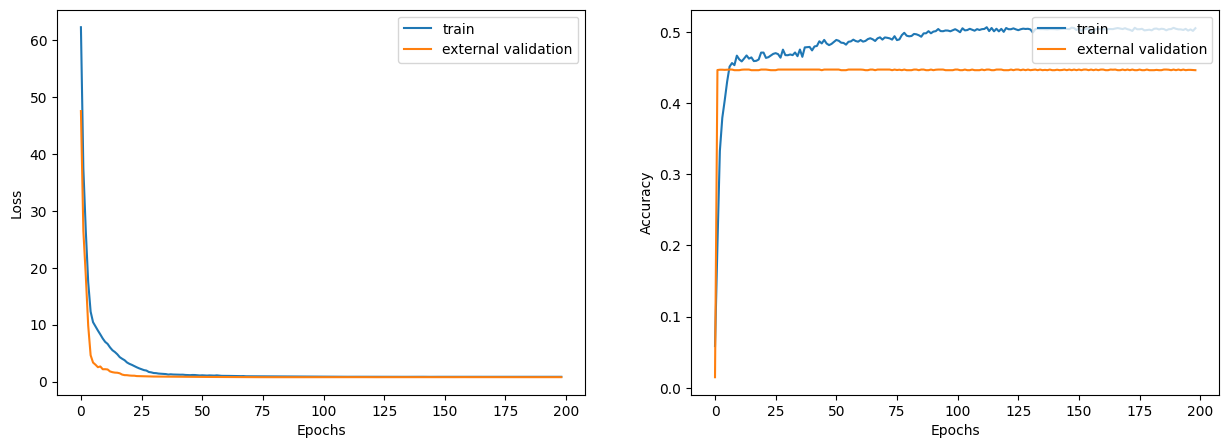

In [12]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external validation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")


fig1 = plt.gcf()
plt.show()



In [13]:
#Predict
for _ in range(loader_test.steps_per_epoch):
    inputs,target = loader_test.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=3)
    print(result)

tf.Tensor(
[[309   0   0]
 [347   0   0]
 [  0   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[292   0   0]
 [346   0   0]
 [ 33   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[205   0   0]
 [330   0   0]
 [ 18   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[378   0   0]
 [484   0   0]
 [  0   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[246   6   0]
 [420   7   0]
 [ 15   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[230   0   0]
 [321   0   0]
 [ 78   0   0]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[171   0   0]
 [247   0   0]
 [ 78   0   0]], shape=(3, 3), dtype=int32)


In [14]:
suma = []
sumatemp = 0
contador = 0
for i in range(len(dataset_test)):
    sumatemp += dataset_test[i].n_nodes
    contador += 1
    if contador == 32:
        suma.append(sumatemp)
        sumatemp = 0
        contador = 0
    elif i == len(dataset_test)-1:
        suma.append(sumatemp)
        
print(suma)

[656, 671, 553, 862, 694, 629, 496]


## Intentos con GAT

In [4]:
dataset=MisProteinas("PROTEINS", transforms=[LayerPreprocess(GATConv)])

Successfully loaded PROTEINS.


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
split = int(0.8 * len(dataset))
dataset_tosplit, dataset_test = dataset[:split], dataset[split:]

split = int(0.8 * len(dataset_tosplit))
dataset_train, dataset_val = dataset_tosplit[:split], dataset_tosplit[split:]

In [9]:

batch_size = 32
loader_train = DisjointLoader(dataset_train, node_level=True,batch_size=batch_size, epochs=200, shuffle=False)
loader_val = DisjointLoader(dataset_val, node_level=True,batch_size=batch_size,shuffle=False)
loader_test = DisjointLoader(dataset_test, node_level=True,batch_size=batch_size,shuffle=False)


In [14]:
# Parameters
channels = 8  # Number of channels in each head of the first GAT layer
n_attn_heads = 8  # Number of attention heads in first GAT layer
dropout = 0.6  # Dropout rate for the features and adjacency matrix
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 5e-3  # Learning rate
epochs = 2000  # Number of training epochs
patience = 100  # Patience for early stopping

N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes


In [15]:
# Model definition
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True)

do_1 = Dropout(dropout)(x_in)
gc_1 = GATConv(
    channels,
    attn_heads=n_attn_heads,
    concat_heads=True,
    dropout_rate=dropout,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_1, a_in])
do_2 = Dropout(dropout)(gc_1)
gc_2 = GATConv(
    n_out,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=dropout,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_2, a_in])


In [16]:
# Build model
model = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dropout_4 (Dropout)            (None, 1)            0           ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 gat_conv_4 (GATConv)           (None, 64)           256         ['dropout_4[0][0]',              
                                                                  'input_6[0][0]']          

In [19]:
# Train model
# loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
# loader_va = SingleLoader(dataset, sample_weights=weights_va)

model.fit(
    loader_train.load(),
    steps_per_epoch=loader_train.steps_per_epoch,
    validation_data=loader_val.load(),
    validation_steps=loader_val.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)


Epoch 1/2000


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_2" expects 2 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1) dtype=float64>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f289c759250>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>]


In [ ]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

## Otro intento con GAT

In [12]:
dataset=proteinas

l2_reg = 2.5e-4
# Define model
x_in = Input(shape=(dataset.n_node_features,))
a_in = Input(shape=(None,), sparse=True)
x_1 = Dropout(0.6)(x_in)
x_1 = GATConv(
    8,
    attn_heads=8,
    concat_heads=True,
    dropout_rate=0.6,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([x_1, a_in])
x_2 = Dropout(0.6)(x_1)
x_2 = GATConv(
    dataset.n_labels,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=0.6,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([x_2, a_in])

In [13]:
# Build model
model = Model(inputs=[x_in, a_in], outputs=x_2)
optimizer = Adam(learning_rate=5e-3)
loss_fn = CategoricalCrossentropy()

In [14]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


ValueError: in user code:

    File "<ipython-input-9-5cb04d2d4fb9>", line 8, in train_step  *
        predictions = model(inputs, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model" expects 2 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'inputs:0' shape=(None, 1) dtype=float64>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7ffa7fae53a0>, <tf.Tensor 'inputs_4:0' shape=(None,) dtype=int64>]


In [11]:
# Training step
@tf.function
def train():
    with tf.GradientTape() as tape:
        predictions = model([x, a], training=True)
        loss = loss_fn(y[mask_tr], predictions[mask_tr])
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [12]:
@tf.function
def evaluate():
    predictions = model([x, a], training=False)
    losses = []
    accuracies = []
    for mask in [mask_tr, mask_va, mask_te]:
        loss = loss_fn(y[mask], predictions[mask])
        loss += sum(model.losses)
        losses.append(loss)
        acc = tf.reduce_mean(categorical_accuracy(y[mask], predictions[mask]))
        accuracies.append(acc)
    return losses, accuracies


In [13]:
best_val_loss = 99999
best_test_acc = 0
current_patience = patience = 100
epochs = 999999
tic()
for epoch in range(1, epochs + 1):
    train()
    l, a = evaluate()
    print(
        "Loss tr: {:.4f}, Acc tr: {:.4f}, "
        "Loss va: {:.4f}, Acc va: {:.4f}, "
        "Loss te: {:.4f}, Acc te: {:.4f}".format(l[0], a[0], l[1], a[1], l[2], a[2])
    )
    if l[1] < best_val_loss:
        best_val_loss = l[1]
        best_test_acc = a[2]
        current_patience = patience
        print("Improved")
    else:
        current_patience -= 1
        if current_patience == 0:
            print("Test accuracy: {}".format(best_test_acc))
            break
toc("GAT ({} epochs)".format(epoch))

NameError: in user code:

    File "<ipython-input-11-8a0b05e70c05>", line 5, in train  *
        predictions = model([x, a], training=True)

    NameError: name 'x' is not defined


---
# GAT con SingleLoader

Adaptación de https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gat.py

In [4]:
dataset=MisProteinas("PROTEINS", transforms=[LayerPreprocess(GATConv)])

Successfully loaded PROTEINS.


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
dataset

MisProteinas(n_graphs=1113)

In [7]:
clase0 = []
clase1 = []
clase2 = []
tot = []

for j in range(1113):
    suma0 = 0
    suma1 = 0
    for i in range(dataset[j].n_nodes):
        if all(dataset[j].y[i] == [1.,0.,0.]):
            suma0+=1
        elif all(dataset[j].y[i] == [0.,1.,0.]):
            suma1+=1
    clase0.append(suma0)
    clase1.append(suma1)
    clase2.append(dataset[j].n_nodes-(suma0+suma1))
    tot.append(dataset[j].n_nodes)
    #print("prot",j+1,":", proteinas[j].n_nodes,"nodos -- clase0:",suma0, " - clase1:", suma1, " - clase2:", proteinas[j].n_nodes-(suma0+suma1))

prot = list(np.arange(1,1114))
a = np.array((tot,clase0,clase1,clase2))
b = pd.DataFrame(a.T, index=prot, columns=["num_nodos", "clase_0", "clase_1", "clase_2"])
print(b.to_string())

      num_nodos  clase_0  clase_1  clase_2
1            42       22       20        0
2            27       14       13        0
3            10        9        1        0
4            24       12       12        0
5            11        3        8        0
6           336      178      158        0
7           108       76       32        0
8           154       81       73        0
9            19       17        2        0
10           11        6        5        0
11           20       12        8        0
12           52       25       27        0
13           21       15        6        0
14           44       26       18        0
15           20       10       10        0
16           40        7       33        0
17           23       11       12        0
18          285      165      120        0
19           56       20       36        0
20           27       18        9        0
21          481      247      234        0
22           54       30       24        0
23         

In [16]:
b.loc[b["num_nodos"] == np.max(b["num_nodos"].to_numpy())]


,num_nodos,clase_0,clase_1,clase_2
77,620,181,439,0


In [25]:
b.loc[b["num_nodos"] == sorted(b["num_nodos"])[-2]]


,num_nodos,clase_0,clase_1,clase_2
245,504,240,264,0


In [36]:
b.loc[b["num_nodos"] == sorted(b["num_nodos"])[-3]]


,num_nodos,clase_0,clase_1,clase_2
21,481,247,234,0


In [5]:
# Parameters
channels = 8  # Number of channels in each head of the first GAT layer
n_attn_heads = 8  # Number of attention heads in first GAT layer
dropout = 0.6  # Dropout rate for the features and adjacency matrix
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 5e-3  # Learning rate
epochs = 2000  # Number of training epochs
patience = 100  # Patience for early stopping

N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes

In [6]:
# Model definition
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True)

do_1 = Dropout(dropout)(x_in)
gc_1 = GATConv(
    channels,
    attn_heads=n_attn_heads,
    concat_heads=True,
    dropout_rate=dropout,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_1, a_in])
do_2 = Dropout(dropout)(gc_1)
gc_2 = GATConv(
    n_out,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=dropout,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_2, a_in])

In [7]:
# Build model
model = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 gat_conv (GATConv)             (None, 64)           256         ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

In [8]:
dataset_train = dataset[76:77]
dataset_val = dataset[244:245]

In [9]:
# Train model
loader_tr = SingleLoader(dataset_train) #, sample_weights=weights_tr)
loader_va = SingleLoader(dataset_val) #, sample_weights=weights_va)
model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    #callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)


Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 3668.2080 - acc: 0.2742 - val_loss: 727.3842 - val_acc: 0.0000e+00
Epoch 2/2000
1/1 [==============================] - 0s 22ms/step - loss: 2730.8000 - acc: 0.4581 - val_loss: 548.0901 - val_acc: 0.5258
Epoch 3/2000
1/1 [==============================] - 0s 21ms/step - loss: 2079.4092 - acc: 0.5065 - val_loss: 482.2743 - val_acc: 0.5238
Epoch 4/2000
1/1 [==============================] - 0s 27ms/step - loss: 2006.4232 - acc: 0.5306 - val_loss: 495.9219 - val_acc: 0.5238
Epoch 5/2000
1/1 [==============================] - 0s 20ms/step - loss: 1773.3728 - acc: 0.5129 - val_loss: 562.2324 - val_acc: 0.5238
Epoch 6/2000
1/1 [==============================] - 0s 23ms/step - loss: 1629.7151 - acc: 0.5581 - val_loss: 648.7039 - val_acc: 0.5238
Epoch 7/2000
1/1 [==============================] - 0s 22ms/step - loss: 1323.6508 - acc: 0.6065 - val_loss: 726.9285 - val_acc: 0.5238
Epoch 8/2000
1/1 [============================

In [10]:
# Evaluate model
print("Evaluating model.")
dataset_test = dataset[20:21]
loader_test = SingleLoader(dataset_test) #, sample_weights=weights_te)
eval_results = model.evaluate(loader_test.load(), steps=loader_test.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
1/1 [==============================] - 0s 477ms/step - loss: 359.2117 - acc: 0.4865
Done.
Test loss: 359.21173095703125
Test accuracy: 0.4864864945411682
